THIS IS THE SAME CODE AS 2017 80/20, FOR COMMENTS AND BETTER STRUCTURED NOTEBOOK CHECK THE 80/20 SPLIT OF THIS NOTEBOOK

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.utils import class_weight, resample
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GRU, LSTM,
    Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
    Flatten, BatchNormalization
)

from keras.models import Sequential as KerasSequential
from keras.layers import GRU as KerasGRU, Dense as KerasDense, Dropout as KerasDropout


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/Kaggle/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!ls -l ~/.kaggle/


total 4
-rw------- 1 root root 68 Mar 16 11:20 kaggle.json


In [ ]:
!kaggle datasets download -d sweety18/cicids2017-full-dataset
!unzip cicids2017-full-dataset.zip -d /content/CICIDS2017


Dataset URL: https://www.kaggle.com/datasets/sweety18/cicids2017-full-dataset
License(s): unknown
 99% 170M/172M [00:07<00:00, 27.6MB/s]
100% 172M/172M [00:07<00:00, 22.5MB/s]
Archive:  cicids2017-full-dataset.zip
  inflating: /content/CICIDS2017/combine.csv  


In [ ]:
!ls -l /content/CICIDS2017


total 668660
-rw-r--r-- 1 root root 684702235 May 30  2020 combine.csv


In [ ]:
file_path = "/content/CICIDS2017/combine.csv"

df = pd.read_csv(file_path, low_memory=False)

df.info()

df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2214469 entries, 0 to 2214468
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             object 
 1    Flow Duration                float64
 2    Total Fwd Packets            float64
 3    Total Backward Packets       float64
 4   Total Length of Fwd Packets   float64
 5    Total Length of Bwd Packets  float64
 6    Fwd Packet Length Max        float64
 7    Fwd Packet Length Min        float64
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         float64
 11   Bwd Packet Length Min        float64
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,55054,109.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,55055,52.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,46236,34.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,54863,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [ ]:
df.columns = df.columns.str.strip()


In [ ]:
df["Label"] = df["Label"].apply(lambda x: 1 if x != "BENIGN" else 0)


In [ ]:
drop_cols = ["Flow ID", "Source IP", "Destination IP", "Timestamp"]
df.drop(columns=[col for col in drop_cols if col in df.columns], errors="ignore", inplace=True)


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Label"])
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")


Training samples: 1550128, Test samples: 664341


In [ ]:


file_path = "/content/CICIDS2017/combine.csv"
df = pd.read_csv(file_path, low_memory=False)

df.columns = df.columns.str.strip()

df["Label"] = df["Label"].apply(lambda x: 1 if x != "BENIGN" else 0)

drop_cols = ["Flow ID", "Source IP", "Destination IP", "Timestamp"]
df.drop(columns=[col for col in drop_cols if col in df.columns], errors="ignore", inplace=True)

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2214469 entries, 0 to 2214468
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             object 
 1   Flow Duration                float64
 2   Total Fwd Packets            float64
 3   Total Backward Packets       float64
 4   Total Length of Fwd Packets  float64
 5   Total Length of Bwd Packets  float64
 6   Fwd Packet Length Max        float64
 7   Fwd Packet Length Min        float64
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        float64
 11  Bwd Packet Length Min        float64
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 float64
 19  

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,55054,109.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,55055,52.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,46236,34.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,54863,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:


input_file = "/content/CICIDS2017/combine.csv"
samples = pd.read_csv(input_file, low_memory=False)

samples.columns = samples.columns.str.strip()

samples["Label"] = samples["Label"].apply(lambda x: 1 if x != "BENIGN" else 0)

samples.replace(['Infinity', np.inf], 0, inplace=True)
samples['Flow Packets/s'] = pd.to_numeric(samples['Flow Packets/s'], errors='coerce').fillna(0)
samples['Flow Bytes/s'] = pd.to_numeric(samples['Flow Bytes/s'], errors='coerce').fillna(0)

drop_cols = ['Source IP', 'Destination IP', 'Flow ID', 'SimillarHTTP', 'Unnamed: 0']
samples.drop(columns=drop_cols, errors='ignore', inplace=True)

train_data, test_data = train_test_split(samples, test_size=0.3, random_state=42, stratify=samples['Label'])

train_output_file = "/content/CICIDS2017/train_data.csv"
test_output_file = "/content/CICIDS2017/test_data.csv"

train_data.to_csv(train_output_file, index=False)
test_data.to_csv(test_output_file, index=False)

print('Training data saved at:', train_output_file)
print('Test data saved at:', test_output_file)


Training data saved at: /content/CICIDS2017/train_data.csv
Test data saved at: /content/CICIDS2017/test_data.csv


In [ ]:

input_file = "/content/CICIDS2017/combine.csv"
output_file = "/content/CICIDS2017/combine_proc.csv"

dtype_spec = {85: str}
df = pd.read_csv(input_file, sep=',', dtype=dtype_spec, low_memory=False)

df.columns = df.columns.str.strip()

df["Label"] = df["Label"].apply(lambda x: 1 if x != "BENIGN" else 0)

df.replace(['Infinity', np.inf], 0, inplace=True)
df['Flow Packets/s'] = pd.to_numeric(df['Flow Packets/s'], errors='coerce').fillna(0)
df['Flow Bytes/s'] = pd.to_numeric(df['Flow Bytes/s'], errors='coerce').fillna(0)

drop_cols = ['Source IP', 'Destination IP', 'Flow ID', 'SimillarHTTP', 'Unnamed: 0']
df.drop(columns=drop_cols, errors='ignore', inplace=True)

df.to_csv(output_file, index=False)
print('Processed dataset saved at:', output_file)


Processed dataset saved at: /content/CICIDS2017/combine_proc.csv


In [ ]:
def train_test(samples):
    from sklearn.model_selection import train_test_split
    import numpy as np

    X=samples.iloc[:,0:(samples.shape[1]-1)]

    y= samples.iloc[:,-1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    return X_train, X_test, y_train, y_test


In [ ]:

def normalise_data(X_train,X_test):
    from sklearn.preprocessing import StandardScaler,MinMaxScaler

    scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)

    X_train = scaler.transform(X_train)

    X_test = scaler.transform(X_test)

    return X_train, X_test


In [ ]:
def format_2d(df):

    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1]))

In [ ]:
import matplotlib.pyplot as plt

def compile_train(model, X_train, y_train, deep=True, model_name="Unknown Model"):
    if deep:
        history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

        print(f"Training Accuracy Plot for: {model_name}")

        plt.plot(history.history['accuracy'])
        plt.title(f'Model Accuracy: {model_name}')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.show()

        return model
    else:
        model.fit(X_train, y_train)
        print(f" {model_name} trained successfully!")
        return model


In [ ]:


def tests(model, X_test, y_test, y_pred, deep=False):
    if deep:
        X_test_3d = format_3d(X_test.copy())

        y_test = np.array(y_test, dtype=np.float32).reshape(-1, 1)

        score = model.evaluate(X_test_3d, y_test, verbose=1)
        print(score)

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    avrg = (acc + prec + rec + f1) / 4

    return acc, prec, rec, f1, avrg



In [ ]:
def test_normal_atk(y_test,y_pred):
    df = pd.DataFrame()
    df['y_test'] = y_test
    df['y_pred'] = y_pred

    normal = len(df.query('y_test == 0'))
    atk = len(y_test)-normal

    wrong = df.query('y_test != y_pred')

    normal_detect_rate = (normal - wrong.groupby('y_test').count().iloc[0][0]) / normal
    atk_detect_rate = (atk - wrong.groupby('y_test').count().iloc[1][0]) / atk


    return normal_detect_rate, atk_detect_rate


In [ ]:
def save_model(model,name):
    from keras.models import model_from_json

    arq_json = 'Models/' + name + '.json'
    model_json = model.to_json()
    with open(arq_json,"w") as json_file:
        json_file.write(model_json)

    arq_h5 = 'Models/' + name + '.h5'
    model.save_weights(arq_h5)
    print('Model Saved')

In [ ]:
def load_model(name):
    from keras.models import model_from_json

    arq_json = 'Models/' + name + '.json'
    json_file = open(arq_json,'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    arq_h5 = 'Models/' + name + '.h5'
    loaded_model.load_weights(arq_h5)

    print('Model loaded')

    return loaded_model

In [ ]:
def save_Sklearn(model,nome):
    import pickle
    arquivo = 'Models/'+ nome + '.pkl'
    with open(arquivo,'wb') as file:
        pickle.dump(model,file)
    print('Model sklearn saved')

In [ ]:
def load_Sklearn(nome):
    import pickle
    arquivo = 'Models/'+ nome + '.pkl'
    with open(arquivo,'rb') as file:
        model = pickle.load(file)
    print('Model sklearn loaded')
    return model

In [ ]:


samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')

samples.columns = samples.columns.str.strip()

X = samples.drop(columns=['Label'])
y = samples['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train_full = pd.concat([X_train, y_train], axis=1)

is_benign = X_train_full['Label'] == 0
normal = X_train_full[is_benign]
ddos = X_train_full[~is_benign]

normal_upsampled = resample(normal,
                            replace=True,
                            n_samples=len(ddos),
                            random_state=27)

upsampled = pd.concat([normal_upsampled, ddos])

X_train = upsampled.drop(columns=['Label'])
y_train = upsampled['Label']

input_size = (X_train.shape[1],)

del X_train_full, normal_upsampled, ddos, upsampled, normal

print("Upsampling complete. Training data is balanced.")


<ipython-input-30-acacc303dd2b>:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


Upsampling complete. Training data is balanced.


In [ ]:
print(GRU_model.__code__.co_varnames)


('input_size', 'model')


<ipython-input-32-d8a49485d7d5>:31: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


Original X_train shape: (1550128, 78)
After format_3d: (1550128, 1, 78)
GRU Expected Input Shape: (1, 78)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 32)                  │          10,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,093 (43.33 KB)

 Trainable params: 11,093 (43.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38754/38754 ━━━━━━━━━━━━━━━━━━━━ 114s 3ms/step - accuracy: 0.8221 - loss: 0.3804 - val_accuracy: 0.9052 - val_loss: 0.2486
Epoch 2/10
38754/38754 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - accuracy: 0.8516 - loss: 0.3318 - val_accuracy: 0.8745 - val_loss: 0.2770
Epoch 3/10
38754/38754 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - accuracy: 0.8510 - loss: 0.3335 - val_accuracy: 0.8732 - val_loss: 0.2736
Epoch 4/10
38754/38754 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - accuracy: 0.8424 - loss: 0.3355 - val_accuracy: 0.8807 - val_loss: 0.2556
Epoch 5/10
38754/38754 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - accuracy: 0.8515 - loss: 0.3223 - val_accuracy: 0.8985 - val_loss: 0.2539
Epoch 6/10
38754/38754 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - accuracy: 0.8465 - loss: 0.3311 - val_accuracy: 0.8800 - val_loss: 0.2807
Epoch 7/10
38754/38754 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - accuracy: 0.8441 - loss: 0.3555 - val_accuracy: 0.8698 - val_loss: 0.2616
Epoch 8/10
38754/38754 ━━━━━━━━━━━━━━━━━━━━ 112s 3ms/step - ac

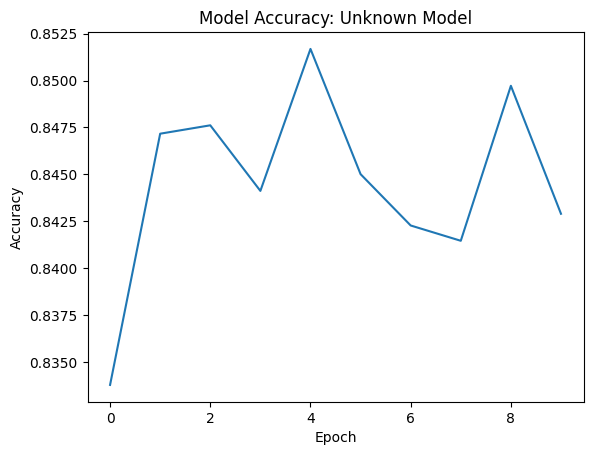

In [ ]:


def GRU_model(input_size):

    model = Sequential()

    model.add(GRU(32, input_shape=(1, input_size[1]), return_sequences=False))

    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()

    return model

def format_3d(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], 1, X.shape[1]))  # (samples, timesteps=1, features)

samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')

samples.columns = samples.columns.str.strip()

X = samples.drop(columns=['Label'])
y = samples['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

if 'Destination Port' in X_train.columns:
    X_train['Destination Port'] = pd.to_numeric(X_train['Destination Port'], errors='coerce')

X_train.dropna(inplace=True)

X_train = X_train.astype(float)

input_size = (1, X_train.shape[1])  # (timesteps, features)

print("Original X_train shape:", X_train.shape)  # Should be (samples, features=78)
print("After format_3d:", format_3d(X_train).shape)  # Should be (samples, 1, 78)
print("GRU Expected Input Shape:", (1, X_train.shape[1]))  # Should match (1, 78)

model_gru = GRU_model(input_size)

model_gru = compile_train(model_gru, format_3d(X_train), y_train)


<ipython-input-33-d08f2275fa98>:35: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


Class Distribution in Training Data:
 Label
0    1170986
1     379142
Name: count, dtype: int64
Original X_train shape: (1550128, 78)
After format_3d: (1550128, 1, 78)
GRU Expected Input Shape: (1, 78)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 32)                  │          10,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,093 (43.33 KB)

 Trainable params: 11,093 (43.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.7646 - loss: 0.5670 - val_accuracy: 0.8062 - val_loss: 0.4252
Epoch 2/25
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.7836 - loss: 0.4737 - val_accuracy: 0.8260 - val_loss: 0.3743
Epoch 3/25
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.7974 - loss: 0.4421 - val_accuracy: 0.7975 - val_loss: 0.3682
Epoch 4/25
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.7957 - loss: 0.4330 - val_accuracy: 0.8209 - val_loss: 0.3677
Epoch 5/25
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.8014 - loss: 0.4373 - val_accuracy: 0.7994 - val_loss: 0.3905
Epoch 6/25
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.7879 - loss: 0.4492 - val_accuracy: 0.8204 - val_loss: 0.4374
Epoch 7/25
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.7962 - loss: 0.4497 - val_accuracy: 0.8210 - val_loss: 0.3958
Epoch 8/25
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 

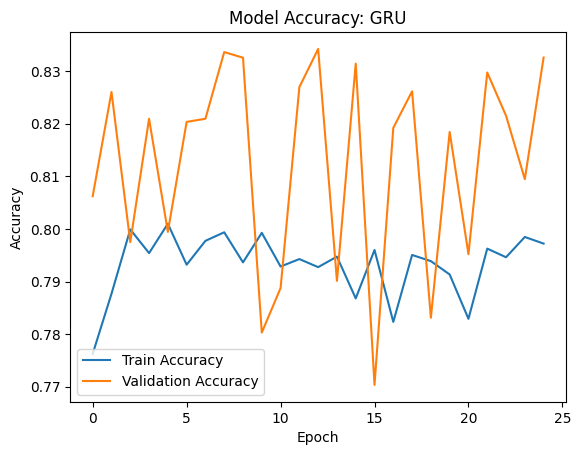

In [ ]:


def GRU_model(input_size):

    model = Sequential()

    model.add(GRU(32, input_shape=(1, input_size[1]), return_sequences=False, kernel_regularizer=l2(0.01)))

    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.summary()

    return model

def format_3d(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], 1, X.shape[1]))  # (samples, timesteps=1, features)

samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')

samples.columns = samples.columns.str.strip()

X = samples.drop(columns=['Label'])
y = samples['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

if 'Destination Port' in X_train.columns:
    X_train['Destination Port'] = pd.to_numeric(X_train['Destination Port'], errors='coerce')

X_train.dropna(inplace=True)

X_train = X_train.astype(float)

print("Class Distribution in Training Data:\n", y_train.value_counts())

input_size = (1, X_train.shape[1])  # (timesteps, features)

print("Original X_train shape:", X_train.shape)  # Should be (samples, features=78)
print("After format_3d:", format_3d(X_train).shape)  # Should be (samples, 1, 78)
print("GRU Expected Input Shape:", (1, X_train.shape[1]))  # Should match (1, 78)

model_gru = GRU_model(input_size)

history = model_gru.fit(
    format_3d(X_train), y_train,
    epochs=25, batch_size=64, validation_split=0.2
)



plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy: GRU')
plt.legend()
plt.show()


<ipython-input-34-61ada66a8949>:33: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


Class Distribution in Training Data:
 Label
0    1170986
1     379142
Name: count, dtype: int64
Original X_train shape: (1550128, 78)
After format_3d: (1550128, 1, 78)
GRU Expected Input Shape: (1, 78)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 32)                  │          10,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,093 (43.33 KB)

 Trainable params: 11,093 (43.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step - accuracy: 0.7907 - loss: 0.5471 - val_accuracy: 0.8454 - val_loss: 0.3793
Epoch 2/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.8012 - loss: 0.4482 - val_accuracy: 0.8350 - val_loss: 0.3566
Epoch 3/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.8077 - loss: 0.4167 - val_accuracy: 0.8465 - val_loss: 0.3736
Epoch 4/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.7912 - loss: 0.4298 - val_accuracy: 0.8373 - val_loss: 0.3565
Epoch 5/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.8025 - loss: 0.4132 - val_accuracy: 0.8601 - val_loss: 0.3158
Epoch 6/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.8005 - loss: 0.4201 - val_accuracy: 0.8238 - val_loss: 0.3290
Epoch 7/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.8018 - loss: 0.4236 - val_accuracy: 0.8653 - val_loss: 0.3487
Epoch 8/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 

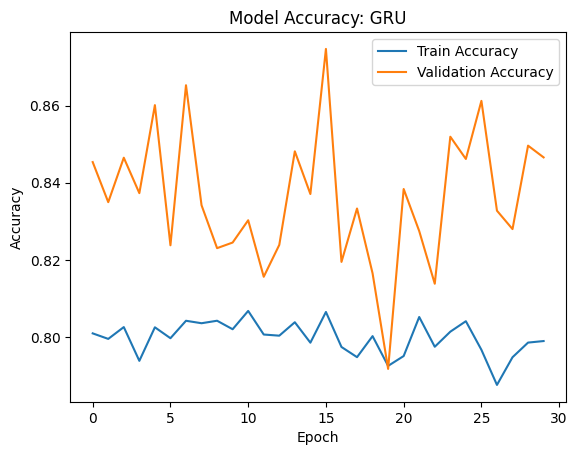

In [ ]:


def GRU_model(input_size):

    model = Sequential()

    model.add(GRU(32, input_shape=(1, input_size[1]), return_sequences=False, kernel_regularizer=l2(0.01)))

    model.add(Dropout(0.6))  # Increased Dropout to 0.6
    model.add(Dense(10, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0003)  # reduced learning rate to 0.0003
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.summary()

    return model

def format_3d(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], 1, X.shape[1]))  # (samples, timesteps=1, features)

samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')
samples.columns = samples.columns.str.strip()
X = samples.drop(columns=['Label'])
y = samples['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

if 'Destination Port' in X_train.columns:
    X_train['Destination Port'] = pd.to_numeric(X_train['Destination Port'], errors='coerce')

X_train.dropna(inplace=True)

X_train = X_train.astype(float)

print("Class Distribution in Training Data:\n", y_train.value_counts())

input_size = (1, X_train.shape[1])

print("Original X_train shape:", X_train.shape)
print("After format_3d:", format_3d(X_train).shape)
print("GRU Expected Input Shape:", (1, X_train.shape[1]))

model_gru = GRU_model(input_size)

history = model_gru.fit(
    format_3d(X_train), y_train,
    epochs=30, batch_size=64, validation_split=0.2
)



plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy: GRU')
plt.legend()
plt.show()


In [ ]:


class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))


<ipython-input-38-4b9ea6a52ec8>:43: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


Class Distribution in Training Data:
 Label
0    1170986
1     379142
Name: count, dtype: int64
Original X_train shape: (1550128, 78)
After format_3d: (1550128, 78, 1)
CNN Expected Input Shape: (78, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 76, 128)             │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 76, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 36, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 36, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 17, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 17, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 8, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,689 (182.38 KB)

 Trainable params: 46,241 (180.63 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 300s 15ms/step - accuracy: 0.9388 - loss: 0.4369 - val_accuracy: 0.8123 - val_loss: 0.5283
Epoch 2/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 296s 15ms/step - accuracy: 0.9649 - loss: 0.1061 - val_accuracy: 0.7849 - val_loss: 0.5300
Epoch 3/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 309s 16ms/step - accuracy: 0.9664 - loss: 0.0993 - val_accuracy: 0.8017 - val_loss: 0.5207
Epoch 4/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 307s 16ms/step - accuracy: 0.9675 - loss: 0.0942 - val_accuracy: 0.3679 - val_loss: 1.1403
Epoch 5/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 305s 16ms/step - accuracy: 0.9684 - loss: 0.0893 - val_accuracy: 0.3827 - val_loss: 3.2938
Epoch 6/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 307s 16ms/step - accuracy: 0.9694 - loss: 0.0860 - val_accuracy: 0.8151 - val_loss: 0.5273
Epoch 7/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 317s 16ms/step - accuracy: 0.9697 - loss: 0.0848 - val_accuracy: 0.3952 - val_loss: 0.8922
Epoch 8/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 310s 16ms/s

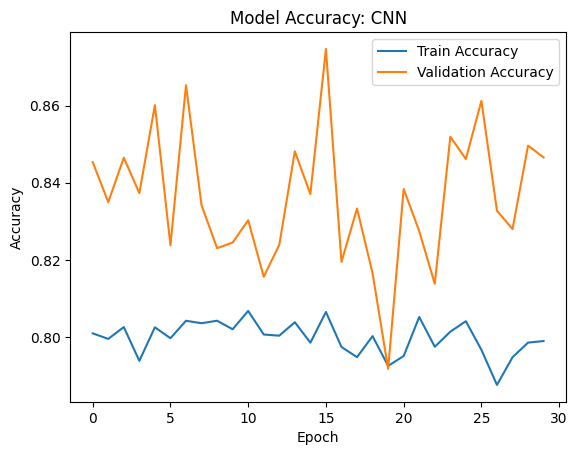

In [ ]:


def CNN_model(input_size):
    model = Sequential()

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(input_size[0], 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))

    model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))

    model.add(Dropout(0.6))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0003)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

def format_3d(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1], 1))

samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')
samples.columns = samples.columns.str.strip()
X = samples.drop(columns=['Label'])
y = samples['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

if 'Destination Port' in X_train.columns:
    X_train['Destination Port'] = pd.to_numeric(X_train['Destination Port'], errors='coerce')

X_train.dropna(inplace=True)

X_train = X_train.astype(float)

print("Class Distribution in Training Data:\n", y_train.value_counts())

input_size = (X_train.shape[1], 1)

print("Original X_train shape:", X_train.shape)
print("After format_3d:", format_3d(X_train).shape)
print("CNN Expected Input Shape:", (X_train.shape[1], 1))

model_cnn = CNN_model(input_size)

model_cnn.fit(
    format_cnn(X_train), y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights
)


import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy: CNN')
plt.legend()
plt.show()


<ipython-input-39-d5539cdc7a1f>:32: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


Class Distribution in Training Data:
 Label
0    1170986
1     379142
Name: count, dtype: int64
Original X_train shape: (1550128, 78)
After format_3d: (1550128, 1, 78)
LSTM Expected Input Shape: (1, 78)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32)                  │          14,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,549 (56.83 KB)

 Trainable params: 14,549 (56.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.7464 - loss: 0.6106 - val_accuracy: 0.8105 - val_loss: 0.4215
Epoch 2/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.7798 - loss: 0.4826 - val_accuracy: 0.7736 - val_loss: 0.4511
Epoch 3/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.7806 - loss: 0.4860 - val_accuracy: 0.8173 - val_loss: 0.4145
Epoch 4/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step - accuracy: 0.7933 - loss: 0.4751 - val_accuracy: 0.7848 - val_loss: 0.4276
Epoch 5/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step - accuracy: 0.7923 - loss: 0.4793 - val_accuracy: 0.8035 - val_loss: 0.4057
Epoch 6/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.7891 - loss: 0.4730 - val_accuracy: 0.8017 - val_loss: 0.4258
Epoch 7/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.7881 - loss: 0.4494 - val_accuracy: 0.8080 - val_loss: 0.4095
Epoch 8/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 

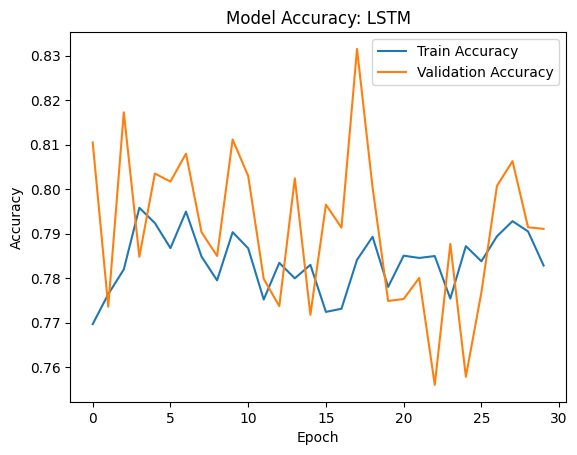

In [ ]:


def LSTM_model(input_size):
    model = Sequential()

    model.add(LSTM(32, input_shape=(1, input_size[1]), return_sequences=False, kernel_regularizer=l2(0.01)))

    model.add(Dropout(0.6))  # Increased Dropout
    model.add(Dense(10, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0003)  # Lowered Learning Rate
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.summary()

    return model

def format_3d(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], 1, X.shape[1]))

samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')
samples.columns = samples.columns.str.strip()
X = samples.drop(columns=['Label'])
y = samples['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

if 'Destination Port' in X_train.columns:
    X_train['Destination Port'] = pd.to_numeric(X_train['Destination Port'], errors='coerce')

X_train.dropna(inplace=True)

X_train = X_train.astype(float)

print("Class Distribution in Training Data:\n", y_train.value_counts())

input_size = (1, X_train.shape[1])

print("Original X_train shape:", X_train.shape)
print("After format_3d:", format_3d(X_train).shape)
print("LSTM Expected Input Shape:", (1, X_train.shape[1]))

model_lstm = LSTM_model(input_size)

history = model_lstm.fit(
    format_3d(X_train), y_train,
    epochs=30, batch_size=64, validation_split=0.2
)



plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy: LSTM')
plt.legend()
plt.show()


<ipython-input-40-d5068b91b76f>:34: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


Class Distribution in Training Data:
 Label
0    1170986
1     379142
Name: count, dtype: int64
Original X_train shape: (1550128, 78)
DNN Expected Input Shape: 78


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 128)                 │          10,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,481 (80.00 KB)

 Trainable params: 20,481 (80.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.7300 - loss: 167454.9844 - val_accuracy: 0.7545 - val_loss: 1.8965
Epoch 2/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.7548 - loss: 18.3109 - val_accuracy: 0.7545 - val_loss: 0.7966
Epoch 3/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.7553 - loss: 3.5305 - val_accuracy: 0.7545 - val_loss: 0.5381
Epoch 4/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.7545 - loss: 0.9479 - val_accuracy: 0.7545 - val_loss: 0.8634
Epoch 5/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.7524 - loss: 0.8704 - val_accuracy: 0.7545 - val_loss: 1.0489
Epoch 6/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.7535 - loss: 0.8984 - val_accuracy: 0.7545 - val_loss: 0.5002
Epoch 7/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.7531 - loss: 0.7494 - val_accuracy: 0.7545 - val_loss: 0.5066
Epoch 8/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accu

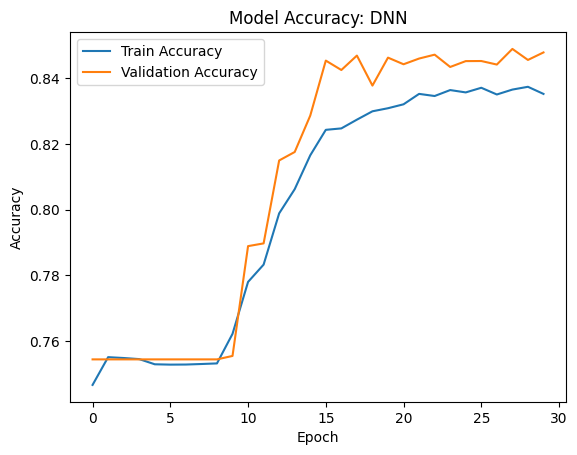

In [ ]:


def DNN_model(input_size):
    model = Sequential()

    model.add(Dense(128, activation='relu', input_shape=(input_size,)))
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0003)  # ✅ Lowered Learning Rate
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.summary()

    return model

samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')
samples.columns = samples.columns.str.strip()
X = samples.drop(columns=['Label'])
y = samples['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

if 'Destination Port' in X_train.columns:
    X_train['Destination Port'] = pd.to_numeric(X_train['Destination Port'], errors='coerce')

X_train.dropna(inplace=True)

X_train = X_train.astype(float)

print("Class Distribution in Training Data:\n", y_train.value_counts())

input_size = X_train.shape[1]

print("Original X_train shape:", X_train.shape)
print("DNN Expected Input Shape:", input_size)

model_dnn = DNN_model(input_size)

history = model_dnn.fit(
    X_train, y_train,
    epochs=30, batch_size=64, validation_split=0.2
)


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy: DNN')
plt.legend()
plt.show()


<ipython-input-41-bd5d45c50340>:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


X_train shape: (1550127, 78)
y_train shape: (1550127,)


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Logistic Regression Accuracy: 0.9154

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94    501852
           1       0.75      0.97      0.85    162489

    accuracy                           0.92    664341
   macro avg       0.87      0.94      0.90    664341
weighted avg       0.93      0.92      0.92    664341



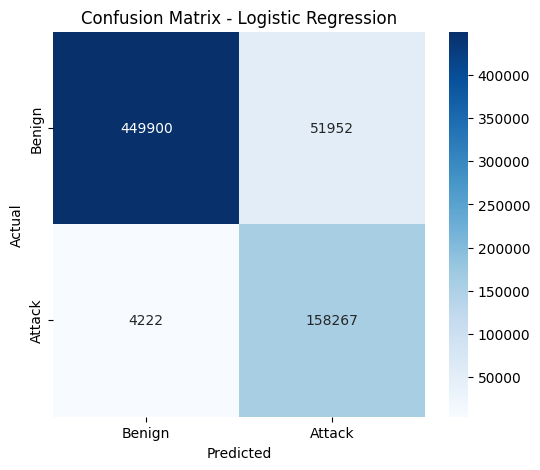

In [ ]:


samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')
samples.columns = samples.columns.str.strip()
samples.dropna(inplace=True)
X = samples.drop(columns=['Label'])
y = samples['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

if 'Destination Port' in X_train.columns:
    X_train['Destination Port'] = pd.to_numeric(X_train['Destination Port'], errors='coerce')

X_train = X_train.astype(float)
X_test = X_test.astype(float)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("X_train shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)

model_lr = LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced', random_state=42)

model_lr.fit(X_train_scaled, y_train)

y_pred = model_lr.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


<ipython-input-42-e3619d8cf7f2>:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


Gradient Descent (SGD) Accuracy: 0.9151

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94    501852
           1       0.75      0.97      0.85    162489

    accuracy                           0.92    664341
   macro avg       0.87      0.93      0.89    664341
weighted avg       0.93      0.92      0.92    664341



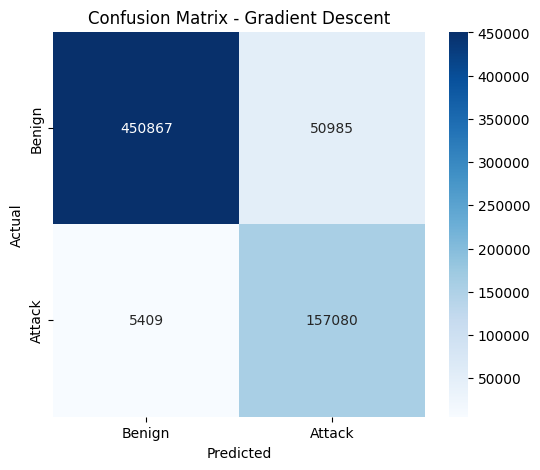

In [ ]:


samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')
samples.columns = samples.columns.str.strip()
samples.dropna(inplace=True)

X = samples.drop(columns=['Label'])
y = samples['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

if 'Destination Port' in X_train.columns:
    X_train['Destination Port'] = pd.to_numeric(X_train['Destination Port'], errors='coerce')

X_train = X_train.astype(float)
X_test = X_test.astype(float)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_gd = SGDClassifier(loss='log_loss',
                         penalty='l2',
                         learning_rate='optimal',
                         class_weight='balanced',
                         random_state=42)

model_gd.fit(X_train_scaled, y_train)

y_pred = model_gd.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Gradient Descent (SGD) Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gradient Descent")
plt.show()


<ipython-input-43-502f7366eec8>:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')


SVM (SGD) Accuracy: 0.9146

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94    501852
           1       0.75      0.98      0.85    162489

    accuracy                           0.91    664341
   macro avg       0.87      0.94      0.89    664341
weighted avg       0.93      0.91      0.92    664341



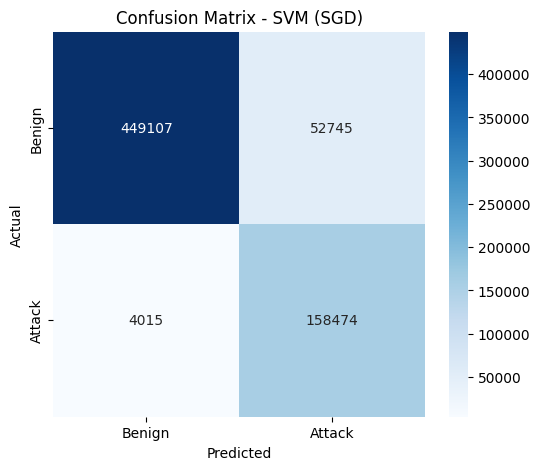

In [ ]:


samples = pd.read_csv('/content/CICIDS2017/combine_proc.csv', sep=',')
samples.columns = samples.columns.str.strip()
samples.dropna(inplace=True)  # drop NaN values at the dataset level

X = samples.drop(columns=['Label'])
y = samples['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

if 'Destination Port' in X_train.columns:
    X_train['Destination Port'] = pd.to_numeric(X_train['Destination Port'], errors='coerce')

X_train = X_train.astype(float)
X_test = X_test.astype(float)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_svm = SGDClassifier(loss='hinge',  #Hinge loss for SVM
                          penalty='l2',  # l2 Regularization
                          learning_rate='optimal',  # automatically adjusts learning rate
                          class_weight='balanced',  # Handle class imbalance
                          random_state=42)

model_svm.fit(X_train_scaled, y_train)

y_pred = model_svm.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"SVM (SGD) Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM (SGD)")
plt.show()


<ipython-input-44-70a0e8029752>:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


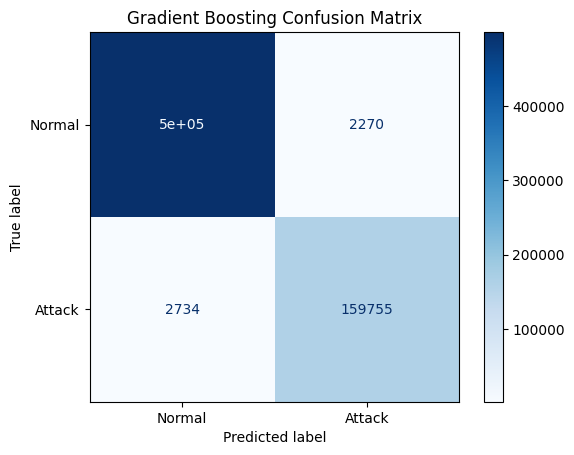

               Model  Accuracy  Precision    Recall  F1-Score  \
0  Gradient Boosting  0.992468    0.98599  0.983174   0.98458   

   Normal Detection Rate  Attack Detection Rate  
0               0.995477               0.983174  


In [ ]:

if 'results' not in globals():
    results = pd.DataFrame(columns=[
        'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'Normal Detection Rate', 'Attack Detection Rate'
    ])

model_gb = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

model_gb.fit(X_train, y_train)

y_pred_gb = model_gb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_gb}).query('y_test != y_pred')

normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': 'Gradient Boosting',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

print(results.tail())


### GRU

In [ ]:
print("Train Class Distribution:\n", y_train.value_counts())
print("Test Class Distribution:\n", y_test.value_counts())


Train Class Distribution:
 Label
0    1170985
1     379142
Name: count, dtype: int64
Test Class Distribution:
 Label
0    501852
1    162489
Name: count, dtype: int64


In [ ]:


class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

history = model_gru.fit(
    format_3d(X_train), y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights  #added here
)


Epoch 1/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - accuracy: 0.7267 - loss: 0.5169 - val_accuracy: 0.6531 - val_loss: 0.5114
Epoch 2/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.7033 - loss: 0.5455 - val_accuracy: 0.8480 - val_loss: 0.3692
Epoch 3/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.7298 - loss: 0.5013 - val_accuracy: 0.7968 - val_loss: 0.3959
Epoch 4/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.7375 - loss: 0.4914 - val_accuracy: 0.7069 - val_loss: 0.4306
Epoch 5/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.7190 - loss: 0.5032 - val_accuracy: 0.8373 - val_loss: 0.4202
Epoch 6/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.7068 - loss: 0.5046 - val_accuracy: 0.7323 - val_loss: 0.4045
Epoch 7/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.7124 - loss: 0.4932 - val_accuracy: 0.8425 - val_loss: 0.3911
Epoch 8/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 

### CNN

In [ ]:
def format_cnn(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1], 1))  # (samples, features, 1)


### LSTM

In [ ]:


class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

history = model_lstm.fit(
    format_3d(X_train), y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights
)


Epoch 1/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.6510 - loss: 0.5634 - val_accuracy: 0.8094 - val_loss: 0.4268
Epoch 2/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.6858 - loss: 0.5560 - val_accuracy: 0.8538 - val_loss: 0.4246
Epoch 3/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.6785 - loss: 0.5647 - val_accuracy: 0.8252 - val_loss: 0.4671
Epoch 4/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.6886 - loss: 0.5581 - val_accuracy: 0.7218 - val_loss: 0.4271
Epoch 5/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.6543 - loss: 0.5851 - val_accuracy: 0.7120 - val_loss: 0.4408
Epoch 6/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.6444 - loss: 0.5643 - val_accuracy: 0.6865 - val_loss: 0.4621
Epoch 7/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.6511 - loss: 0.5547 - val_accuracy: 0.8735 - val_loss: 0.4355
Epoch 8/30
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 

In [ ]:
def test_normal_atk(y_test, y_pred):
    y_test = y_test.ravel()  # flatten to 1D
    y_pred = y_pred.ravel()

    test_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    normal = (test_df['y_test'] == 0).sum()
    atk = (test_df['y_test'] == 1).sum()

    wrong = test_df[test_df['y_test'] != test_df['y_pred']]
    wrong_counts = wrong.groupby('y_test').size()

    wrong_norm = wrong_counts.get(0, 0)
    wrong_atk = wrong_counts.get(1, 0)

    normal_detect_rate = (normal - wrong_norm) / normal if normal else 0
    atk_detect_rate = (atk - wrong_atk) / atk if atk else 0

    return normal_detect_rate, atk_detect_rate


🔍 Evaluating GRU...
20761/20761 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step


<ipython-input-49-0e802b84da54>:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test = y_test.ravel()  # flatten to 1D


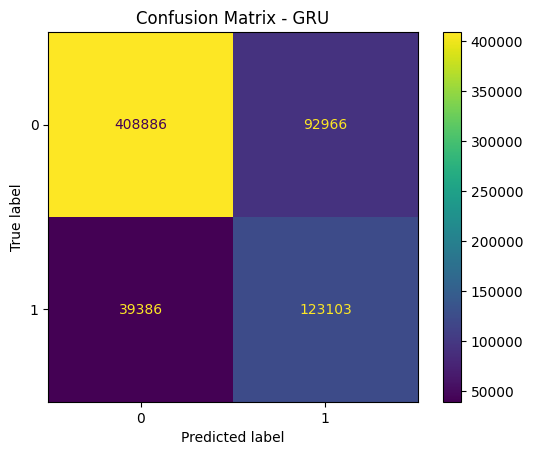

🔍 Evaluating LSTM...
20761/20761 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step


<ipython-input-49-0e802b84da54>:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test = y_test.ravel()  # flatten to 1D


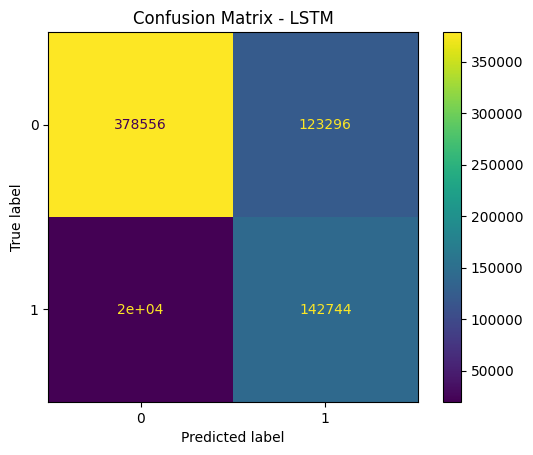

,Method,Accuracy,Precision,Recall,F1_Score,Average,Normal_Detect_Rate,Atk_Detect_Rate
0,GRU,0.800777,0.569739,0.757608,0.650379,0.694626,0.814754,0.757608
1,LSTM,0.784687,0.536551,0.878484,0.666205,0.716482,0.754318,0.878484


In [ ]:


models = [('GRU', model_gru), ('LSTM', model_lstm)]
results_list = []

for name, model in models:
    print(f"🔍 Evaluating {name}...")

    X_input = format_3d(X_test)  # Works for both GRU and LSTM
    y_pred = model.predict(X_input).round()

    acc, prec, rec, f1, avg = tests(model, X_input, y_test, y_pred)
    norm, atk = test_normal_atk(y_test, y_pred)

    results_list.append({
        'Method': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1_Score': f1,
        'Average': avg,
        'Normal_Detect_Rate': norm,
        'Atk_Detect_Rate': atk
    })

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

results_df = pd.DataFrame(results_list)
display(results_df)


In [ ]:
def format_3d(df):
    X = np.array(df)
    return X.reshape(X.shape[0], X.shape[1], 1)  # (samples, timesteps, features)


In [ ]:
X_test_cnn = format_3d(X_test)  # (samples, 78, 1)
y_pred_cnn = model_cnn.predict(X_test_cnn)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int)


20761/20761 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step


20761/20761 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step


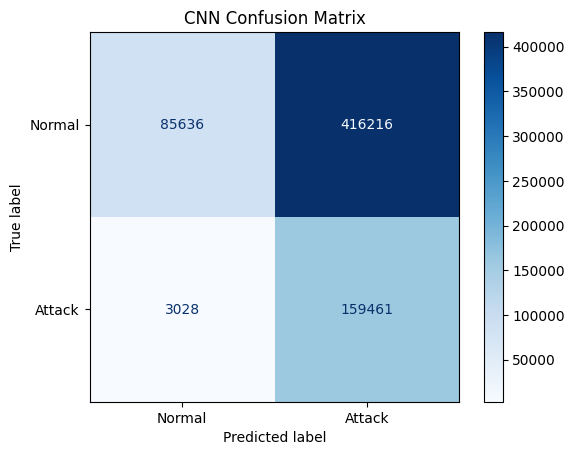

               Model  Accuracy  Precision    Recall  F1-Score  \
0  Gradient Boosting  0.992468   0.985990  0.983174  0.984580   
1                CNN  0.368933   0.276997  0.981365  0.432046   

   Normal Detection Rate  Attack Detection Rate  
0               0.995477               0.983174  
1               0.170640               0.981365  


In [ ]:
X_test_cnn = format_3d(X_test)  # reshape to (samples, 78, 1)
y_pred_cnn = model_cnn.predict(X_test_cnn)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_cnn)
precision = precision_score(y_test, y_pred_cnn)
recall = recall_score(y_test, y_pred_cnn)
f1 = f1_score(y_test, y_pred_cnn)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_cnn.flatten()}).query('y_test != y_pred')
normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': 'CNN',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("CNN Confusion Matrix")
plt.show()

print(results.tail())


20761/20761 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step


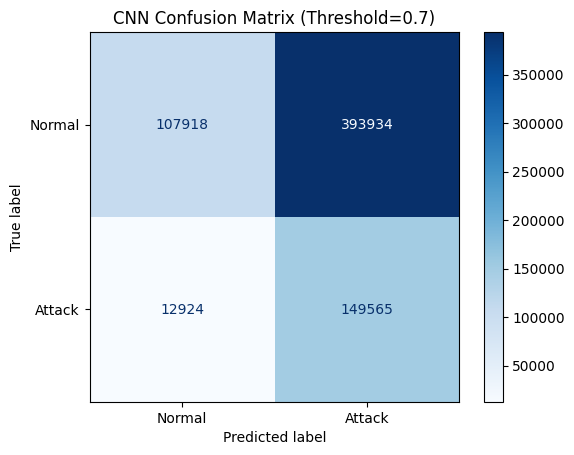

                 Model  Accuracy  Precision    Recall  F1-Score  \
0    Gradient Boosting  0.992468   0.985990  0.983174  0.984580   
1                  CNN  0.368933   0.276997  0.981365  0.432046   
2  CNN (Threshold=0.7)  0.387577   0.275189  0.920462  0.423704   

   Normal Detection Rate  Attack Detection Rate  
0               0.995477               0.983174  
1               0.170640               0.981365  
2               0.215039               0.920462  


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X_test_cnn = format_3d(X_test)  # (samples, 78, 1)
y_pred_prob_cnn = model_cnn.predict(X_test_cnn)

threshold = 0.7
y_pred_cnn = (y_pred_prob_cnn > threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred_cnn)
precision = precision_score(y_test, y_pred_cnn)
recall = recall_score(y_test, y_pred_cnn)
f1 = f1_score(y_test, y_pred_cnn)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_cnn.flatten()}).query('y_test != y_pred')
normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': f'CNN (Threshold={threshold})',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title(f"CNN Confusion Matrix (Threshold={threshold})")
plt.show()

print(results.tail())


In [ ]:
class_weights = {0: 5, 1: 1}  # Heavier penalty on misclassifying normal as attacks

model_cnn.fit(
    format_3d(X_train), y_train, epochs=10, batch_size=64,
    validation_split=0.2, class_weight=class_weights
)


Epoch 1/10
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 302s 16ms/step - accuracy: 0.9791 - loss: 0.1184 - val_accuracy: 0.8241 - val_loss: 8.8131
Epoch 2/10
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 300s 15ms/step - accuracy: 0.9807 - loss: 0.1093 - val_accuracy: 0.8381 - val_loss: 1.3665
Epoch 3/10
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 300s 15ms/step - accuracy: 0.9813 - loss: 0.1053 - val_accuracy: 0.8385 - val_loss: 1.4906
Epoch 4/10
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 300s 15ms/step - accuracy: 0.9819 - loss: 0.1024 - val_accuracy: 0.8376 - val_loss: 0.4486
Epoch 5/10
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 299s 15ms/step - accuracy: 0.9818 - loss: 0.1039 - val_accuracy: 0.8458 - val_loss: 0.5056
Epoch 6/10
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 299s 15ms/step - accuracy: 0.9821 - loss: 0.1011 - val_accuracy: 0.8406 - val_loss: 0.4546
Epoch 7/10
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 303s 16ms/step - accuracy: 0.9818 - loss: 0.1024 - val_accuracy: 0.8240 - val_loss: 0.5145
Epoch 8/10
19377/19377 ━━━━━━━━━━━━━━━━━━━━ 301s 16ms/s

In [ ]:
threshold = 0.7
y_pred_cnn = (model_cnn.predict(format_3d(X_test)) > threshold).astype(int)


20761/20761 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step


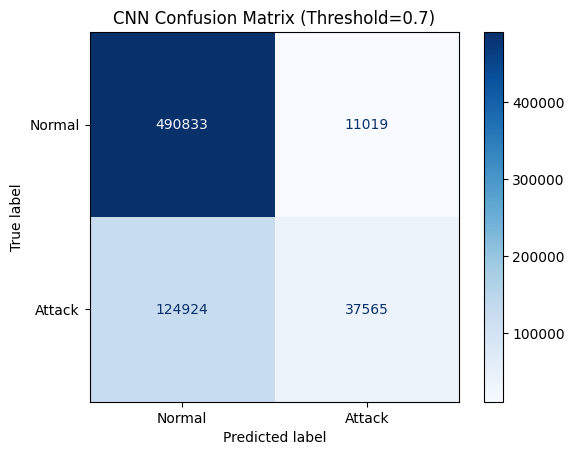

In [ ]:
cm = confusion_matrix(y_test, y_pred_cnn)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("CNN Confusion Matrix (Threshold=0.7)")
plt.show()


20761/20761 ━━━━━━━━━━━━━━━━━━━━ 20s 943us/step


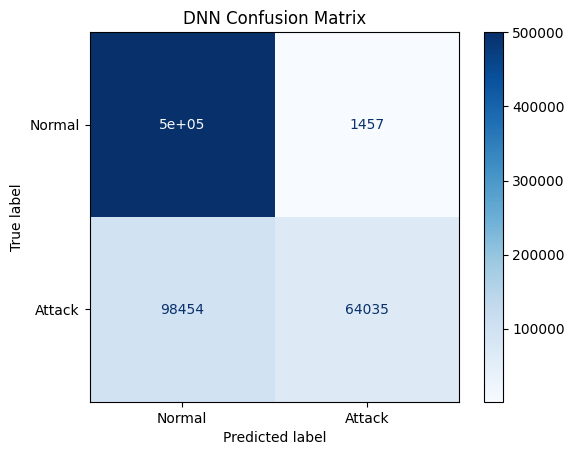

              precision    recall  f1-score   support

      Normal       0.84      1.00      0.91    501852
      Attack       0.98      0.39      0.56    162489

    accuracy                           0.85    664341
   macro avg       0.91      0.70      0.74    664341
weighted avg       0.87      0.85      0.82    664341

                 Model  Accuracy  Precision    Recall  F1-Score  \
0    Gradient Boosting  0.992468   0.985990  0.983174  0.984580   
1                  CNN  0.368933   0.276997  0.981365  0.432046   
2  CNN (Threshold=0.7)  0.387577   0.275189  0.920462  0.423704   
3                  DNN  0.849609   0.977753  0.394088  0.561757   

   Normal Detection Rate  Attack Detection Rate  
0               0.995477               0.983174  
1               0.170640               0.981365  
2               0.215039               0.920462  
3               0.997097               0.394088  


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred_dnn = model_dnn.predict(X_test).round().astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred_dnn)
precision = precision_score(y_test, y_pred_dnn)
recall = recall_score(y_test, y_pred_dnn)
f1 = f1_score(y_test, y_pred_dnn)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_dnn}).query('y_test != y_pred')
normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': 'DNN',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_dnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("DNN Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_dnn, target_names=['Normal', 'Attack']))

print(results.tail())


In [ ]:
threshold = 0.3
y_pred_dnn = (model_dnn.predict(X_test) > threshold).astype(int).flatten()


20761/20761 ━━━━━━━━━━━━━━━━━━━━ 19s 932us/step


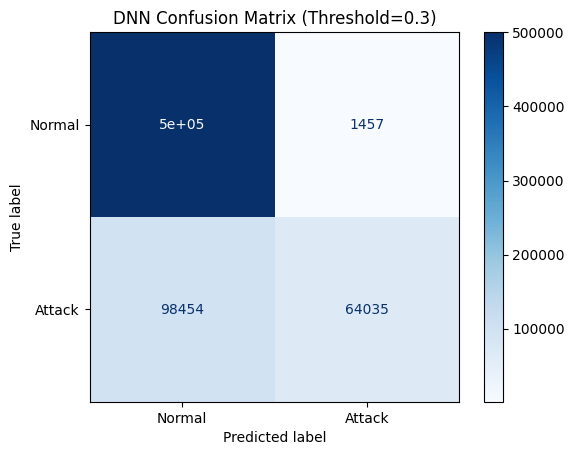

              precision    recall  f1-score   support

      Normal       0.84      0.99      0.91    501852
      Attack       0.96      0.40      0.56    162489

    accuracy                           0.85    664341
   macro avg       0.90      0.70      0.74    664341
weighted avg       0.87      0.85      0.82    664341



In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title(f"DNN Confusion Matrix (Threshold={threshold})")
plt.show()

print(classification_report(y_test, y_pred_dnn, target_names=['Normal', 'Attack']))


20761/20761 ━━━━━━━━━━━━━━━━━━━━ 20s 977us/step


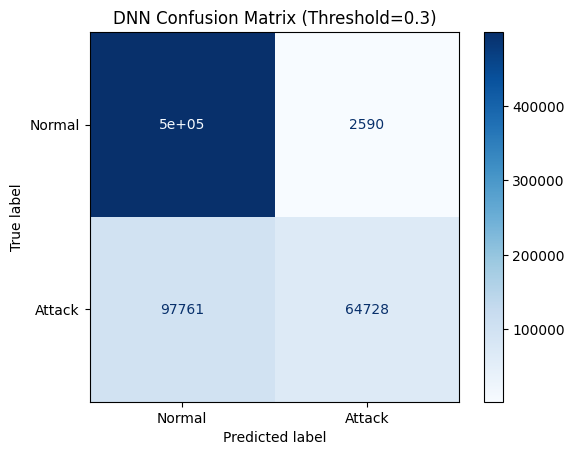

              precision    recall  f1-score   support

      Normal       0.84      0.99      0.91    501852
      Attack       0.96      0.40      0.56    162489

    accuracy                           0.85    664341
   macro avg       0.90      0.70      0.74    664341
weighted avg       0.87      0.85      0.82    664341

                 Model  Accuracy  Precision    Recall  F1-Score  \
0    Gradient Boosting  0.992468   0.985990  0.983174  0.984580   
1                  CNN  0.368933   0.276997  0.981365  0.432046   
2  CNN (Threshold=0.7)  0.387577   0.275189  0.920462  0.423704   
3                  DNN  0.849609   0.977753  0.394088  0.561757   
4  DNN (Threshold=0.3)  0.848947   0.961526  0.398353  0.563325   

   Normal Detection Rate  Attack Detection Rate  
0               0.995477               0.983174  
1               0.170640               0.981365  
2               0.215039               0.920462  
3               0.997097               0.394088  
4               0.99

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

threshold = 0.3
y_pred_dnn = (model_dnn.predict(X_test) > threshold).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred_dnn)
precision = precision_score(y_test, y_pred_dnn)
recall = recall_score(y_test, y_pred_dnn)
f1 = f1_score(y_test, y_pred_dnn)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_dnn}).query('y_test != y_pred')

normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': f'DNN (Threshold={threshold})',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_dnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title(f"DNN Confusion Matrix (Threshold={threshold})")
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_dnn, target_names=['Normal', 'Attack']))

print(results.tail())


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


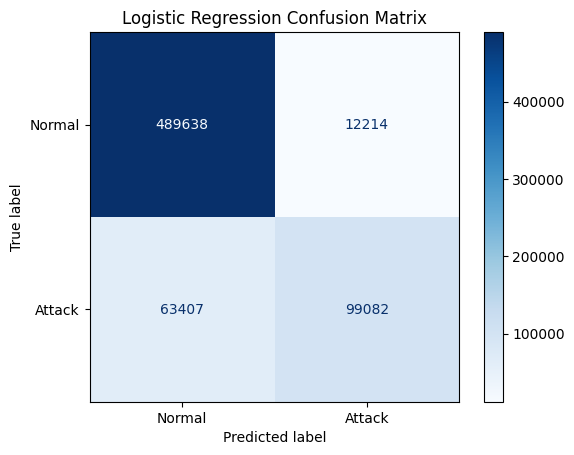

              precision    recall  f1-score   support

      Normal       0.89      0.98      0.93    501852
      Attack       0.89      0.61      0.72    162489

    accuracy                           0.89    664341
   macro avg       0.89      0.79      0.83    664341
weighted avg       0.89      0.89      0.88    664341

                 Model  Accuracy  Precision    Recall  F1-Score  \
1                  CNN  0.368933   0.276997  0.981365  0.432046   
2  CNN (Threshold=0.7)  0.387577   0.275189  0.920462  0.423704   
3                  DNN  0.849609   0.977753  0.394088  0.561757   
4  DNN (Threshold=0.3)  0.848947   0.961526  0.398353  0.563325   
5  Logistic Regression  0.886171   0.890257  0.609777  0.723794   

   Normal Detection Rate  Attack Detection Rate  
1               0.170640               0.981365  
2               0.215039               0.920462  
3               0.997097               0.394088  
4               0.994839               0.398353  
5               0.97

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import pandas as pd

if 'results' not in globals():
    results = pd.DataFrame(columns=[
        'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'Normal Detection Rate', 'Attack Detection Rate'
    ])

model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_lr}).query('y_test != y_pred')
normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': 'Logistic Regression',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_lr, target_names=['Normal', 'Attack']))

print(results.tail())


In [ ]:
threshold = 0.4
y_pred_lr_prob = model_lr.predict_proba(X_test)[:, 1]
y_pred_lr = (y_pred_lr_prob > threshold).astype(int)


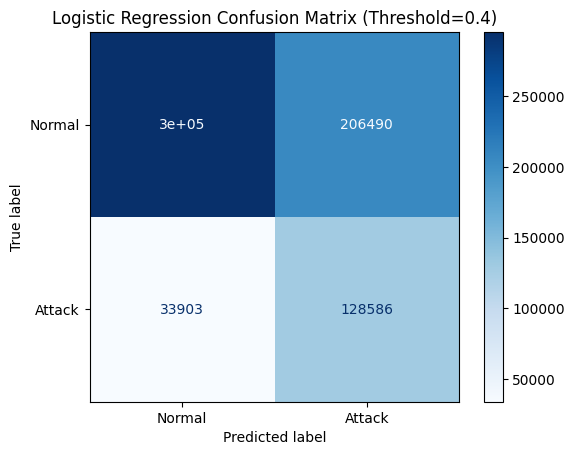

              precision    recall  f1-score   support

      Normal       0.90      0.59      0.71    501852
      Attack       0.38      0.79      0.52    162489

    accuracy                           0.64    664341
   macro avg       0.64      0.69      0.61    664341
weighted avg       0.77      0.64      0.66    664341



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_lr)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title(f"Logistic Regression Confusion Matrix (Threshold={threshold})")
plt.show()

print(classification_report(y_test, y_pred_lr, target_names=['Normal', 'Attack']))


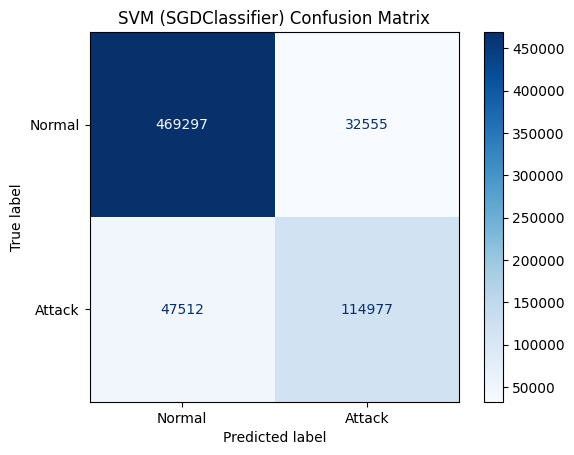

              precision    recall  f1-score   support

      Normal       0.91      0.94      0.92    501852
      Attack       0.78      0.71      0.74    162489

    accuracy                           0.88    664341
   macro avg       0.84      0.82      0.83    664341
weighted avg       0.88      0.88      0.88    664341

                 Model  Accuracy  Precision    Recall  F1-Score  \
2  CNN (Threshold=0.7)  0.387577   0.275189  0.920462  0.423704   
3                  DNN  0.849609   0.977753  0.394088  0.561757   
4  DNN (Threshold=0.3)  0.848947   0.961526  0.398353  0.563325   
5  Logistic Regression  0.886171   0.890257  0.609777  0.723794   
6  SVM (SGDClassifier)  0.879479   0.779336  0.707599  0.741737   

   Normal Detection Rate  Attack Detection Rate  
2               0.215039               0.920462  
3               0.997097               0.394088  
4               0.994839               0.398353  
5               0.975662               0.609777  
6               0.93

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import pandas as pd

if 'results' not in globals():
    results = pd.DataFrame(columns=[
        'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'Normal Detection Rate', 'Attack Detection Rate'
    ])

model_svm = SGDClassifier(loss='hinge', random_state=42)
model_svm.fit(X_train, y_train)

y_pred_svm = model_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_svm}).query('y_test != y_pred')
normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': 'SVM (SGDClassifier)',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("SVM (SGDClassifier) Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_svm, target_names=['Normal', 'Attack']))

print(results.tail())


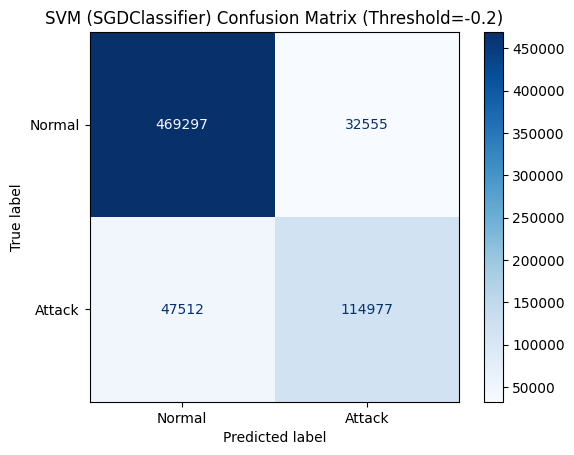

              precision    recall  f1-score   support

      Normal       0.91      0.94      0.92    501852
      Attack       0.78      0.71      0.74    162489

    accuracy                           0.88    664341
   macro avg       0.84      0.82      0.83    664341
weighted avg       0.88      0.88      0.88    664341



In [ ]:
threshold = -0.2
y_pred_svm_decision = model_svm.decision_function(X_test)
y_pred_svm = (y_pred_svm_decision > threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_svm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title(f"SVM (SGDClassifier) Confusion Matrix (Threshold={threshold})")
plt.show()

print(classification_report(y_test, y_pred_svm, target_names=['Normal', 'Attack']))


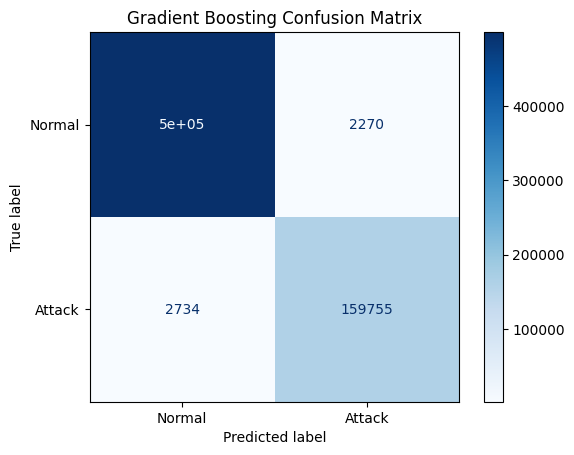

              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00    501852
      Attack       0.99      0.98      0.98    162489

    accuracy                           0.99    664341
   macro avg       0.99      0.99      0.99    664341
weighted avg       0.99      0.99      0.99    664341

                 Model  Accuracy  Precision    Recall  F1-Score  \
3                  DNN  0.849609   0.977753  0.394088  0.561757   
4  DNN (Threshold=0.3)  0.848947   0.961526  0.398353  0.563325   
5  Logistic Regression  0.886171   0.890257  0.609777  0.723794   
6  SVM (SGDClassifier)  0.879479   0.779336  0.707599  0.741737   
7    Gradient Boosting  0.992468   0.985990  0.983174  0.984580   

   Normal Detection Rate  Attack Detection Rate  
3               0.997097               0.394088  
4               0.994839               0.398353  
5               0.975662               0.609777  
6               0.935130               0.707599  
7               0.99

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import pandas as pd

if 'results' not in globals():
    results = pd.DataFrame(columns=[
        'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'Normal Detection Rate', 'Attack Detection Rate'
    ])

model_gb = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

model_gb.fit(X_train, y_train)

y_pred_gb = model_gb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_gb}).query('y_test != y_pred')
normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': 'Gradient Boosting',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_gb, target_names=['Normal', 'Attack']))

print(results.tail())


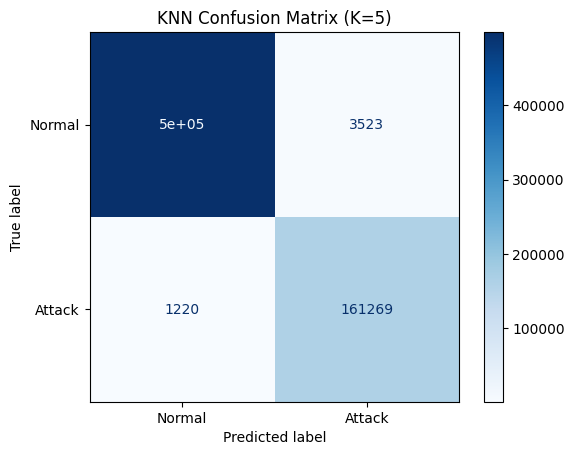

              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00    501852
      Attack       0.98      0.99      0.99    162489

    accuracy                           0.99    664341
   macro avg       0.99      0.99      0.99    664341
weighted avg       0.99      0.99      0.99    664341

                       Model  Accuracy  Precision    Recall  F1-Score  \
4        DNN (Threshold=0.3)  0.848947   0.961526  0.398353  0.563325   
5        Logistic Regression  0.886171   0.890257  0.609777  0.723794   
6        SVM (SGDClassifier)  0.879479   0.779336  0.707599  0.741737   
7          Gradient Boosting  0.992468   0.985990  0.983174  0.984580   
8  K-Nearest Neighbors (K=5)  0.992861   0.978622  0.992492  0.985508   

   Normal Detection Rate  Attack Detection Rate  
4               0.994839               0.398353  
5               0.975662               0.609777  
6               0.935130               0.707599  
7               0.995477          

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import pandas as pd

if 'results' not in globals():
    results = pd.DataFrame(columns=[
        'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'Normal Detection Rate', 'Attack Detection Rate'
    ])

model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_knn}).query('y_test != y_pred')
normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': 'K-Nearest Neighbors (K=5)',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("KNN Confusion Matrix (K=5)")
plt.show()

print(classification_report(y_test, y_pred_knn, target_names=['Normal', 'Attack']))

print(results.tail())


20761/20761 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step


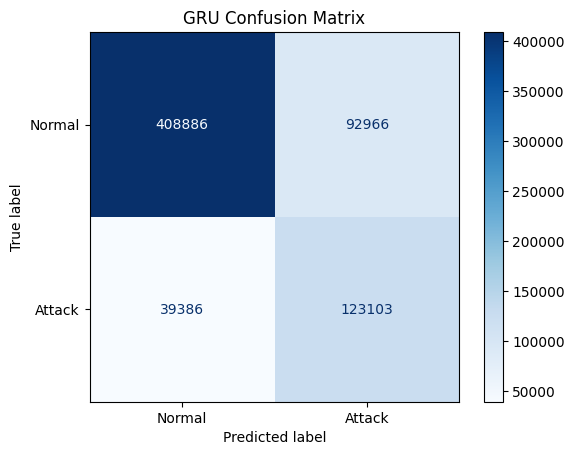

              precision    recall  f1-score   support

      Normal       0.91      0.81      0.86    501852
      Attack       0.57      0.76      0.65    162489

    accuracy                           0.80    664341
   macro avg       0.74      0.79      0.76    664341
weighted avg       0.83      0.80      0.81    664341

                       Model  Accuracy  Precision    Recall  F1-Score  \
5        Logistic Regression  0.886171   0.890257  0.609777  0.723794   
6        SVM (SGDClassifier)  0.879479   0.779336  0.707599  0.741737   
7          Gradient Boosting  0.992468   0.985990  0.983174  0.984580   
8  K-Nearest Neighbors (K=5)  0.992861   0.978622  0.992492  0.985508   
9                        GRU  0.800777   0.569739  0.757608  0.650379   

   Normal Detection Rate  Attack Detection Rate  
5               0.975662               0.609777  
6               0.935130               0.707599  
7               0.995477               0.983174  
8               0.992980          

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def format_3d(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], 1, X.shape[1]))  # Fixes the input shape issue

threshold = 0.5
y_pred_gru = (model_gru.predict(format_3d(X_test)) > threshold).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred_gru)
precision = precision_score(y_test, y_pred_gru)
recall = recall_score(y_test, y_pred_gru)
f1 = f1_score(y_test, y_pred_gru)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_gru}).query('y_test != y_pred')
normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': 'GRU',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_gru)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("GRU Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_gru, target_names=['Normal', 'Attack']))

print(results.tail())


20761/20761 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step


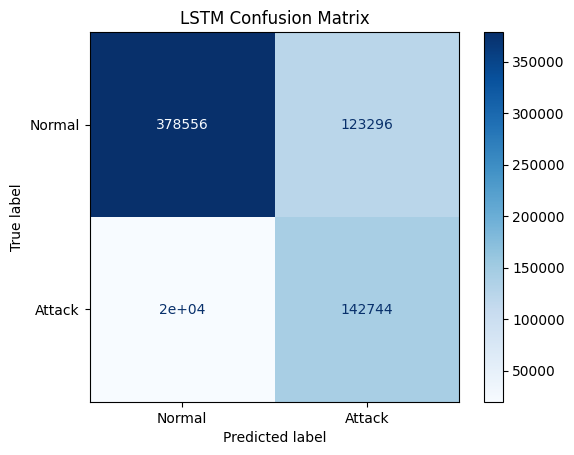

              precision    recall  f1-score   support

      Normal       0.95      0.75      0.84    501852
      Attack       0.54      0.88      0.67    162489

    accuracy                           0.78    664341
   macro avg       0.74      0.82      0.75    664341
weighted avg       0.85      0.78      0.80    664341

                        Model  Accuracy  Precision    Recall  F1-Score  \
6         SVM (SGDClassifier)  0.879479   0.779336  0.707599  0.741737   
7           Gradient Boosting  0.992468   0.985990  0.983174  0.984580   
8   K-Nearest Neighbors (K=5)  0.992861   0.978622  0.992492  0.985508   
9                         GRU  0.800777   0.569739  0.757608  0.650379   
10                       LSTM  0.784687   0.536551  0.878484  0.666205   

    Normal Detection Rate  Attack Detection Rate  
6                0.935130               0.707599  
7                0.995477               0.983174  
8                0.992980               0.992492  
9                0.81475

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def format_3d(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], 1, X.shape[1]))  # timesteps=1, features=78

threshold = 0.5
y_pred_lstm = (model_lstm.predict(format_3d(X_test)) > threshold).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred_lstm)
precision = precision_score(y_test, y_pred_lstm)
recall = recall_score(y_test, y_pred_lstm)
f1 = f1_score(y_test, y_pred_lstm)

wrong_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_lstm}).query('y_test != y_pred')
normal = (y_test == 0).sum()
atk = (y_test == 1).sum()

normal_detect_rate = (normal - wrong_preds.query('y_test == 0').shape[0]) / normal
atk_detect_rate = (atk - wrong_preds.query('y_test == 1').shape[0]) / atk

new_row = pd.DataFrame([{
    'Model': 'LSTM',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Normal Detection Rate': normal_detect_rate,
    'Attack Detection Rate': atk_detect_rate
}])

results = pd.concat([results, new_row], ignore_index=True)

cm = confusion_matrix(y_test, y_pred_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')
plt.title("LSTM Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_lstm, target_names=['Normal', 'Attack']))

print(results.tail())


In [ ]:
results


,Model,Accuracy,Precision,Recall,F1-Score,Normal Detection Rate,Attack Detection Rate
0,Gradient Boosting,0.992468,0.985990,0.983174,0.984580,0.995477,0.983174
1,CNN,0.368933,0.276997,0.981365,0.432046,0.170640,0.981365
2,CNN (Threshold=0.7),0.387577,0.275189,0.920462,0.423704,0.215039,0.920462
3,DNN,0.849609,0.977753,0.394088,0.561757,0.997097,0.394088
4,DNN (Threshold=0.3),0.848947,0.961526,0.398353,0.563325,0.994839,0.398353
5,Logistic Regression,0.886171,0.890257,0.609777,0.723794,0.975662,0.609777
6,SVM (SGDClassifier),0.879479,0.779336,0.707599,0.741737,0.935130,0.707599
7,Gradient Boosting,0.992468,0.985990,0.983174,0.984580,0.995477,0.983174
8,K-Nearest Neighbors (K=5),0.992861,0.978622,0.992492,0.985508,0.992980,0.992492
9,GRU,0.800777,0.569739,0.757608,0.650379,0.814754,0.757608


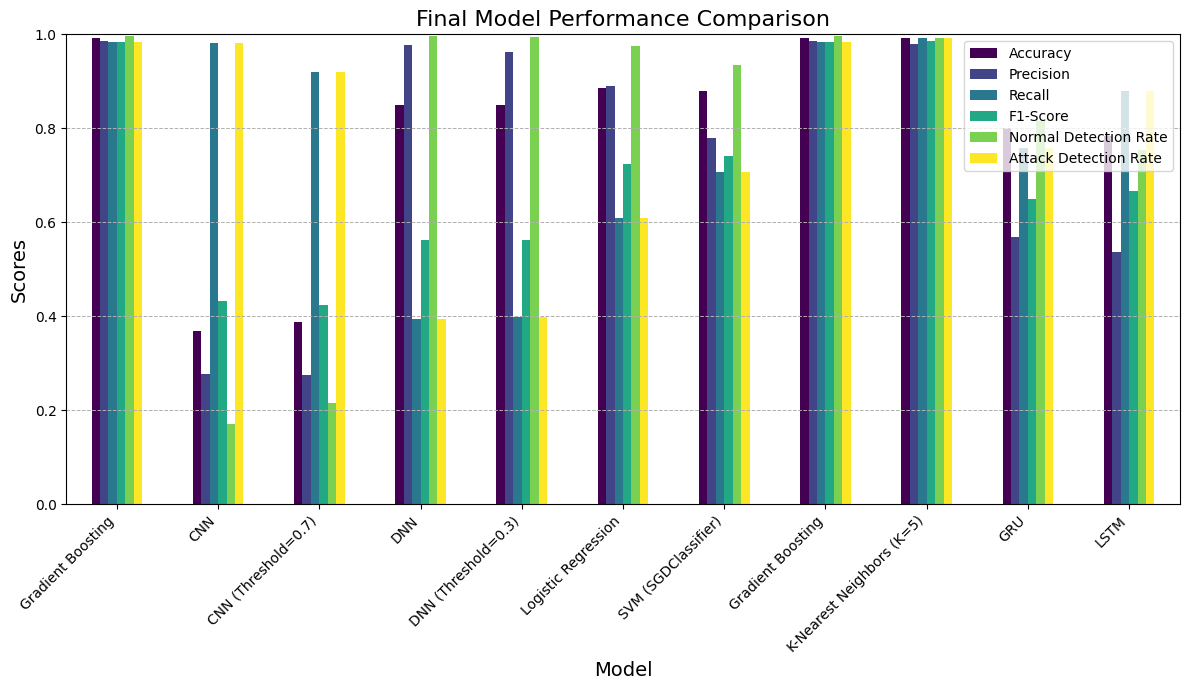

                        Model  Accuracy  Precision    Recall  F1-Score  \
0           Gradient Boosting  0.992468   0.985990  0.983174  0.984580   
1                         CNN  0.368933   0.276997  0.981365  0.432046   
2         CNN (Threshold=0.7)  0.387577   0.275189  0.920462  0.423704   
3                         DNN  0.849609   0.977753  0.394088  0.561757   
4         DNN (Threshold=0.3)  0.848947   0.961526  0.398353  0.563325   
5         Logistic Regression  0.886171   0.890257  0.609777  0.723794   
6         SVM (SGDClassifier)  0.879479   0.779336  0.707599  0.741737   
7           Gradient Boosting  0.992468   0.985990  0.983174  0.984580   
8   K-Nearest Neighbors (K=5)  0.992861   0.978622  0.992492  0.985508   
9                         GRU  0.800777   0.569739  0.757608  0.650379   
10                       LSTM  0.784687   0.536551  0.878484  0.666205   

    Normal Detection Rate  Attack Detection Rate  
0                0.995477               0.983174  
1        

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

expected_models = ['GRU', 'LSTM', 'CNN', 'DNN', 'SVM (SGDClassifier)',
                   'Logistic Regression', 'Gradient Boosting', 'K-Nearest Neighbors (K=5)']

missing_models = set(expected_models) - set(results['Model'])
if missing_models:
    print(f"⚠️ Warning: Missing models from results: {missing_models}")
else:
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score',
               'Normal Detection Rate', 'Attack Detection Rate']

    results_plot = results.set_index('Model')[metrics]
    results_plot.plot(kind='bar', figsize=(12, 7), colormap='viridis')

    plt.title('Final Model Performance Comparison', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Scores', fontsize=14)
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', linewidth=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='upper right')
    plt.tight_layout()

    plt.show()

print(results)
